# NYC Taxi Fare Prediction 🚕

**Gabriele Cola** - **Swann Etro**

### 0. Libraries

In [ ]:
# Importing data
import pandas as pd
import geopandas as gpd
import numpy as np
import google.cloud.bigquery
from google.cloud import bigquery

# Stats
from scipy.stats import zscore
from statsmodels.tsa.stattools import adfuller


# Data Visualization
import seaborn as sns
import folium
from folium.plugins import HeatMap, MarkerCluster

import plotly
import plotly.express as px

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches

import shapely

# Modelling
import sklearn as sk
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV,   RandomizedSearchCV
from sklearn.metrics import mean_squared_error,r2_score,silhouette_score,mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.cluster import KMeans, DBSCAN


from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import mlflow
import mlflow.sklearn
    

import nbformat

# Save model
import joblib

import db_dtypes






In [28]:
import sys
sys.path.append('./Functions')
import pre_processing 
from pre_processing import *
import feature_engineering
from feature_engineering import *

### 1. Importing

In [3]:
client = bigquery.Client(project='nyc-taxi-project-455608')

In [4]:
query= """
SELECT *
 FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2022`
 ORDER BY RAND()
 LIMIT 100000
"""

df = client.query(query).to_dataframe()
df.head()

/Users/gabrielecola/anaconda3/envs/NYC_Taxi/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,rate_code,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,imp_surcharge,airport_fee,total_amount,pickup_location_id,dropoff_location_id,data_file_year,data_file_month
0,2,2022-04-15 11:28:25+00:00,2022-04-15 11:41:41+00:00,1,1.500000000,1.0,N,2,9.500000000,0E-9,0.500000000,0E-9,0E-9,0.300000000,0E-9,12.800000000,90,224,2022,4
1,1,2022-01-15 23:16:04+00:00,2022-01-15 23:27:53+00:00,2,2.800000000,1.0,N,1,11.000000000,3.000000000,0.500000000,2.950000000,0E-9,0.300000000,0E-9,17.750000000,142,90,2022,1
2,2,2022-09-30 10:08:24+00:00,2022-09-30 10:31:51+00:00,1,1.380000000,1.0,N,1,15.000000000,0E-9,0.500000000,2.500000000,0E-9,0.300000000,0E-9,20.800000000,170,237,2022,9
3,1,2022-04-06 11:29:07+00:00,2022-04-06 11:38:55+00:00,2,1.100000000,1.0,N,1,7.500000000,2.500000000,0.500000000,2.000000000,0E-9,0.300000000,0E-9,12.800000000,163,236,2022,4
4,2,2022-10-20 16:32:34+00:00,2022-10-20 16:51:13+00:00,1,2.850000000,1.0,N,1,14.000000000,1.000000000,0.500000000,3.660000000,0E-9,0.300000000,0E-9,21.960000000,166,236,2022,10


### 2. Pre-Processing

#### 2.1 Changing Type of Features

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype              
---  ------               --------------   -----              
 0   vendor_id            100000 non-null  object             
 1   pickup_datetime      100000 non-null  datetime64[us, UTC]
 2   dropoff_datetime     100000 non-null  datetime64[us, UTC]
 3   passenger_count      96530 non-null   Int64              
 4   trip_distance        100000 non-null  object             
 5   rate_code            96530 non-null   object             
 6   store_and_fwd_flag   96530 non-null   object             
 7   payment_type         100000 non-null  object             
 8   fare_amount          100000 non-null  object             
 9   extra                100000 non-null  object             
 10  mta_tax              100000 non-null  object             
 11  tip_amount           100000 non-null  object             
 12  tol

In [6]:

cols_to_convert = ['trip_distance', 'fare_amount', 'extra', 'mta_tax',
                   'tip_amount', 'tolls_amount', 'imp_surcharge',
                   'airport_fee', 'total_amount']

for col in cols_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce') 

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype              
---  ------               --------------   -----              
 0   vendor_id            100000 non-null  object             
 1   pickup_datetime      100000 non-null  datetime64[us, UTC]
 2   dropoff_datetime     100000 non-null  datetime64[us, UTC]
 3   passenger_count      96530 non-null   Int64              
 4   trip_distance        100000 non-null  float64            
 5   rate_code            96530 non-null   object             
 6   store_and_fwd_flag   96530 non-null   object             
 7   payment_type         100000 non-null  object             
 8   fare_amount          100000 non-null  float64            
 9   extra                100000 non-null  float64            
 10  mta_tax              100000 non-null  float64            
 11  tip_amount           100000 non-null  float64            
 12  tol

#### 2.2 Checking NA

In [8]:
df.isnull().sum()

vendor_id                 0
pickup_datetime           0
dropoff_datetime          0
passenger_count        3470
trip_distance             0
rate_code              3470
store_and_fwd_flag     3470
payment_type              0
fare_amount               0
extra                     0
mta_tax                   0
tip_amount                0
tolls_amount              0
imp_surcharge             0
airport_fee            3470
total_amount              0
pickup_location_id        0
dropoff_location_id       0
data_file_year            0
data_file_month           0
dtype: int64

In [16]:
df = mean_impute_columns(df, ['passenger_count', 'rate_code','store_and_fwd_flag','airport_fee'])

In [17]:
df.isnull().sum()

vendor_id              0
pickup_datetime        0
dropoff_datetime       0
passenger_count        0
trip_distance          0
rate_code              0
store_and_fwd_flag     0
payment_type           0
fare_amount            0
extra                  0
mta_tax                0
tip_amount             0
tolls_amount           0
imp_surcharge          0
airport_fee            0
total_amount           0
pickup_location_id     0
dropoff_location_id    0
data_file_year         0
data_file_month        0
dtype: int64

#### 2.3 Removing Outlier

In [18]:

Q1 = df['trip_distance'].quantile(0.01)
Q3 = df['trip_distance'].quantile(0.99)
IQR = Q3 - Q1


lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR


df = df[(df['trip_distance'] >= lower_limit) & (df['trip_distance'] <= upper_limit)]


df[['trip_distance']].describe()

,trip_distance
count,99991.000000
mean,3.492419
std,4.409357
min,0.000000
25%,1.100000
50%,1.900000
75%,3.560000
max,50.130000


### 3. EDA

In [19]:
describe_df = df.describe().transpose().round(2)
unit_dict = {
    'trip_distance': 'miles',
    'fare_amount': '$',
    'extra': '$',
    'mta_tax': '$',
    'tip_amount': '$',
    'tolls_amount': '$',
    'imp_surcharge': '$',
    'airport_fee': '$',
    'total_amount': '$',
    'passenger_count': 'people',
    'data_file_year': 'year',
    'data_file_month': 'month'
}

describe_df['measurment units'] = describe_df.index.map(unit_dict).fillna('-') 

describe_df.reset_index().rename(columns={"index": "variabile"})

,variabile,count,mean,std,min,25%,50%,75%,max,measurment units
0,passenger_count,99991.0,1.384155,0.94663,0.0,1.0,1.0,1.0,6.0,people
1,trip_distance,99991.0,3.492419,4.409357,0.0,1.1,1.9,3.56,50.13,miles
2,fare_amount,99991.0,14.663606,26.099525,-175.0,7.0,10.0,16.06,6984.0,$
3,extra,99991.0,0.990897,1.239442,-4.5,0.0,0.5,2.5,8.25,$
4,mta_tax,99991.0,0.488915,0.092569,-0.55,0.5,0.5,0.5,2.54,$
5,tip_amount,99991.0,2.702935,3.221629,-0.86,0.7,2.15,3.36,225.0,$
6,tolls_amount,99991.0,0.527825,1.983472,-26.3,0.0,0.0,0.0,40.94,$
7,imp_surcharge,99991.0,0.296118,0.047713,-0.3,0.3,0.3,0.3,0.3,$
8,airport_fee,99991.0,0.092608,0.331094,-1.25,0.0,0.0,0.0,1.25,$
9,total_amount,99991.0,21.393523,28.073691,-186.6,12.3,15.95,22.8,6987.3,$


#### 3.1 Average duration, distance, and fare of trips

In [20]:
df['trip_duration_minutes'] = (df['dropoff_datetime'] - df['pickup_datetime']).dt.total_seconds() / 60


valid_duration_distance = df[
    (df['trip_duration_minutes'] > 0) &
    (df['trip_distance'] > 0)
]


average_duration = valid_duration_distance['trip_duration_minutes'].mean()
average_distance = valid_duration_distance['trip_distance'].mean()
average_fare = df['fare_amount'].mean()


print(f"Average Duration: {average_duration:.2f} minuti")
print(f"Average Distance: {average_distance:.2f} miglia")
print(f"Average Fare: ${average_fare:.2f}")

Average Duration: 17.38 minuti
Average Distance: 3.54 miglia
Average Fare: $14.66


#### 3.2 Most popular pickup and drop-off locations

In [21]:
popular_pickups = df["pickup_location_id"].value_counts().reset_index()
popular_pickups.columns = ['Pickup_ID', 'Count']

popular_dropoffs = df["dropoff_location_id"].value_counts().reset_index()
popular_dropoffs.columns = ['Dropoff_ID', 'Count']


top_combined = pd.concat([popular_pickups, popular_dropoffs], axis=1)
top_combined.head(15)

,Pickup_ID,Count,Dropoff_ID,Count
0,132,4748.0,236,4218
1,237,4705.0,237,3983
2,236,4107.0,161,3675
3,161,3939.0,170,3040
4,186,3307.0,230,2953
5,162,3166.0,142,2770
6,142,3136.0,239,2750
7,230,3077.0,141,2702
8,170,3019.0,48,2673
9,48,3006.0,162,2532


#### 3.3 Peak hours

In [22]:
df["pickup_hour"] = df["pickup_datetime"].dt.strftime("%H:00")

hourly_trips = df["pickup_hour"].value_counts()

print(hourly_trips.head(10))

pickup_hour
18:00    7059
17:00    6722
19:00    6421
15:00    6349
16:00    6155
14:00    6108
13:00    5596
12:00    5564
20:00    5521
11:00    5200
Name: count, dtype: int64


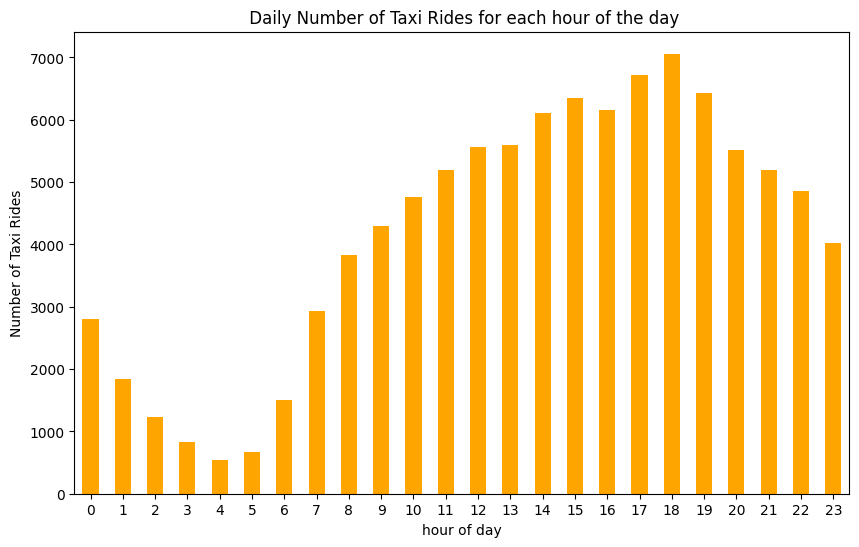

In [23]:
# Daily Number of Taxi Rides for each hour of the day
df['pickup_hour'] = df['pickup_datetime'].dt.hour
hourly_trips = df['pickup_hour'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
hourly_trips.plot(kind='bar', color='orange')
plt.title(" Daily Number of Taxi Rides for each hour of the day")
plt.xlabel("hour of day")
plt.ylabel("Number of Taxi Rides")
plt.xticks(rotation=0)
plt.grid(False)
plt.show()

#### 3.4 Analysis of seasonality and stationarity

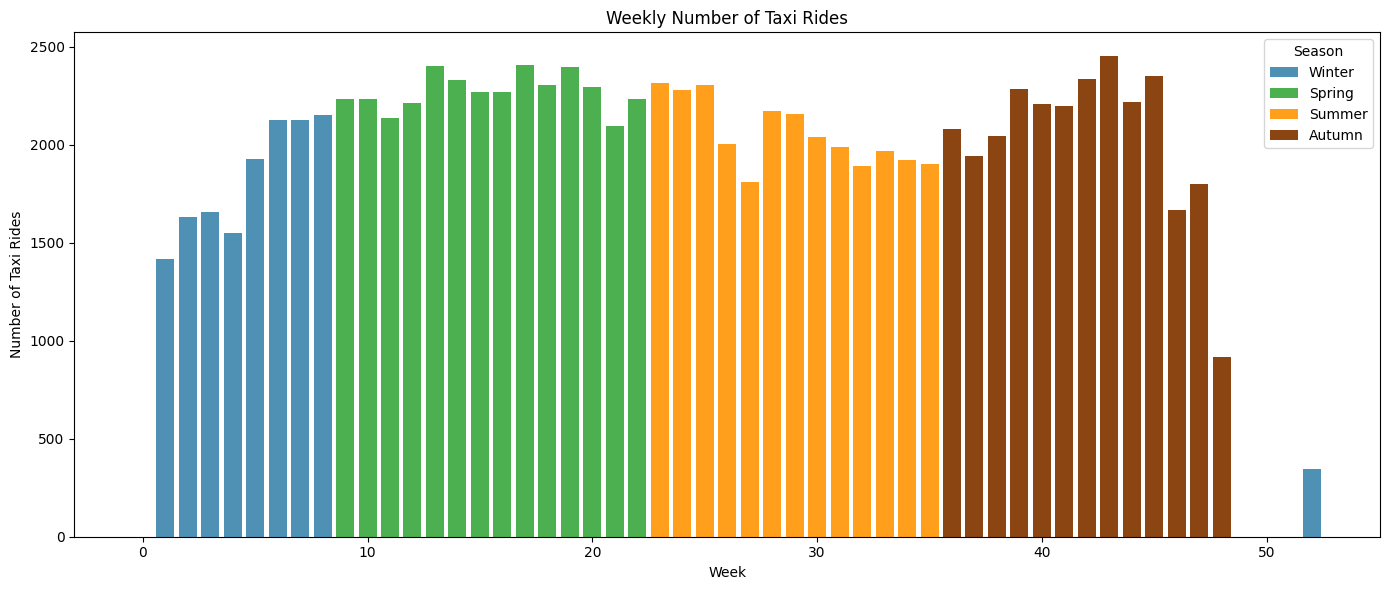

In [24]:
weekly_trips = df['pickup_datetime'].dt.isocalendar().week.value_counts().sort_index()

season_labels = [get_season(w) for w in weekly_trips.index]

# Colours per seasonality
season_colors = {
    'Winter': '#4F91B5',  # blu freddo (più scuro)
    'Spring': '#4CAF50',  # verde brillante, fresco
    'Summer': '#FF9F1C',     # giallo caldo e solare
    'Autumn': '#8B4513'     # marrone caldo e terroso
}
colors = [season_colors[s] for s in season_labels]

# Plot
plt.figure(figsize=(14, 6))
plt.bar(weekly_trips.index, weekly_trips.values, color=colors)

# Legend
for season, color in season_colors.items():
    plt.bar(0, 0, color=color, label=season)  # dummy bars for legend

plt.title("Weekly Number of Taxi Rides")
plt.xlabel("Week")
plt.ylabel("Number of Taxi Rides")
plt.legend(title="Season")
plt.tight_layout()
plt.grid(False)
plt.show()


In [25]:
# 5. Test Dickey-Fuller for stationarity
result = adfuller(weekly_trips)

print("✅ Test di Dickey-Fuller:")
print(f"Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print("Critial Values:")
for key, value in result[4].items():
    print(f"   {key}: {value}")

# Interpretazione
if result[1] < 0.05:
    print("\n✅ The series is stationary (we reject null hypothesis)")
else:
    print("\n❌ The series is not stationary (we cannot reject the null hypothesis)")

✅ Test di Dickey-Fuller:
Statistic: 0.02788902479793368
p-value: 0.9607786104217347
Critial Values:
   1%: -3.5745892596209488
   5%: -2.9239543084490744
   10%: -2.6000391840277777

❌ The series is not stationary (we cannot reject the null hypothesis)


#### 3.5 Anomalous Trips: Very Long Durations for Short Distances

In [ ]:
'''
plt.figure(figsize=(10, 6))
sns.histplot(df['trip_duration_minutes'], bins=100, kde=True)
plt.title('Distribution of Trip Durations (minutes)')
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Frequency')
plt.xlim(0, 100)
plt.grid(False)
plt.show()
'''

"\nplt.figure(figsize=(10, 6))\nsns.histplot(df['trip_duration_minutes'], bins=100, kde=True)\nplt.title('Distribution of Trip Durations (minutes)')\nplt.xlabel('Trip Duration (minutes)')\nplt.ylabel('Frequency')\nplt.xlim(0, 100)\nplt.grid(False)\nplt.show()\n"

In [ ]:
'''
# Trova viaggi con bassa distanza ma durata lunga
anomalous_trips = df[
    ((df['trip_distance'] < 1) &
    (df['trip_duration_minutes'] > 40)
    | (df['trip_duration_minutes'] > 300))
]

# Mostra una tabella (prime 10 righe)
print("🔍 Outlier Trips founded:", len(anomalous_trips))
# display(anomalous_trips[['pickup_datetime', 'dropoff_datetime', 'trip_distance', 'trip_duration_minutes']].head(10))

# Grafico a dispersione: tutti i viaggi (grigi), anomalie (rossi)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='trip_distance', y='trip_duration_minutes', color='lightgray', label='Normal', alpha=0.5)
sns.scatterplot(data=anomalous_trips, x='trip_distance', y='trip_duration_minutes', color='red', label='Outlier ')
plt.title('Evidence of Outlier Trips')
plt.xlabel('Distance (miles)')
plt.ylabel('Duration (minutes)')
plt.grid(False)
plt.show()
'''

'\n# Trova viaggi con bassa distanza ma durata lunga\nanomalous_trips = df[\n    ((df[\'trip_distance\'] < 1) &\n    (df[\'trip_duration_minutes\'] > 40)\n    | (df[\'trip_duration_minutes\'] > 300))\n]\n\n# Mostra una tabella (prime 10 righe)\nprint("🔍 Outlier Trips founded:", len(anomalous_trips))\n# display(anomalous_trips[[\'pickup_datetime\', \'dropoff_datetime\', \'trip_distance\', \'trip_duration_minutes\']].head(10))\n\n# Grafico a dispersione: tutti i viaggi (grigi), anomalie (rossi)\nplt.figure(figsize=(10, 6))\nsns.scatterplot(data=df, x=\'trip_distance\', y=\'trip_duration_minutes\', color=\'lightgray\', label=\'Normal\', alpha=0.5)\nsns.scatterplot(data=anomalous_trips, x=\'trip_distance\', y=\'trip_duration_minutes\', color=\'red\', label=\'Outlier \')\nplt.title(\'Evidence of Outlier Trips\')\nplt.xlabel(\'Distance (miles)\')\nplt.ylabel(\'Duration (minutes)\')\nplt.grid(False)\nplt.show()\n'

### 3.6 Correlation Heatmap

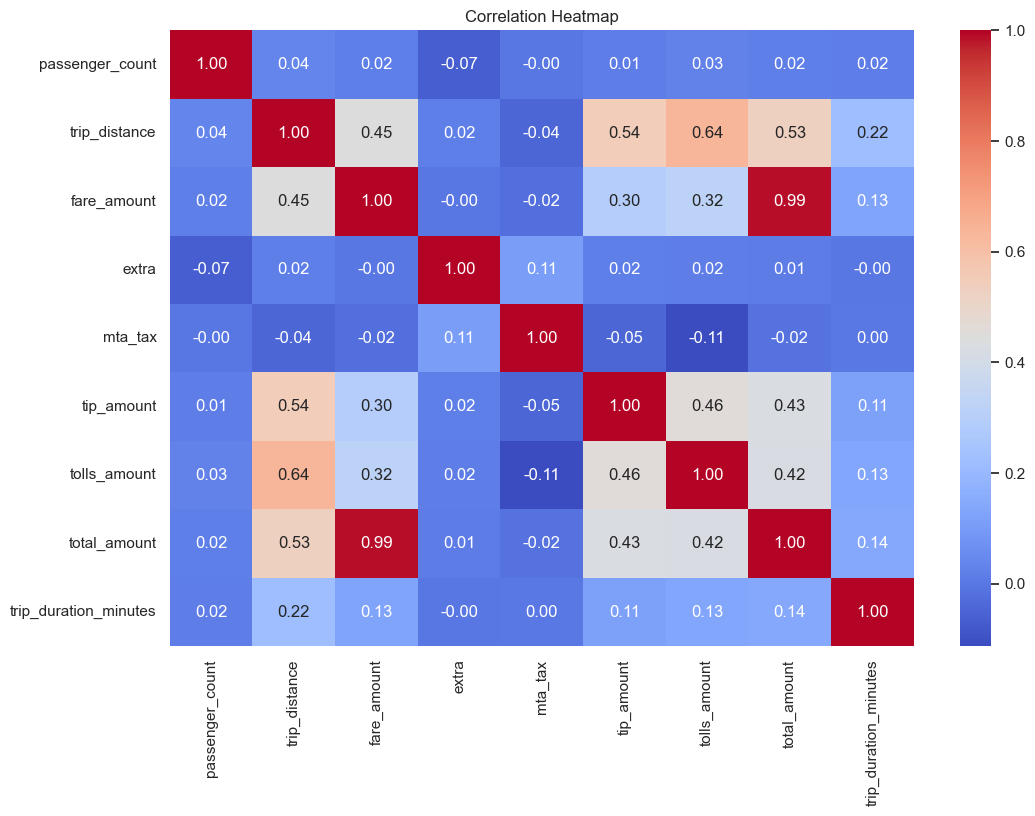

In [59]:
# Numerical features
numeric_cols = ['passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'total_amount', 'trip_duration_minutes']
corr = df[numeric_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

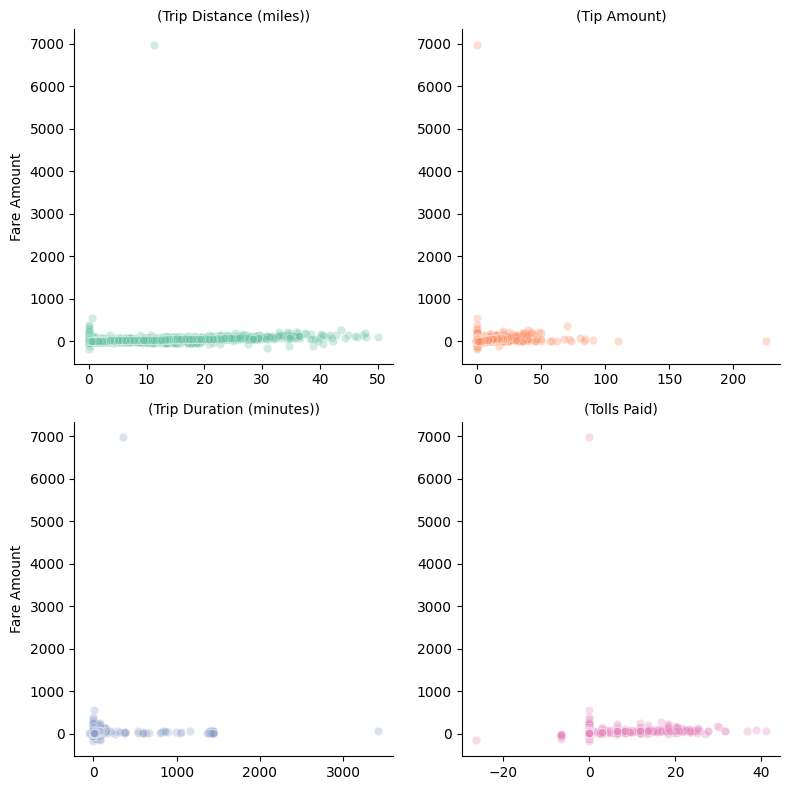

In [27]:
# Select 4 key features
feature_labels = {
    'trip_distance': 'Trip Distance (miles)',
    'tip_amount': 'Tip Amount',
    'trip_duration_minutes': 'Trip Duration (minutes)',
    'tolls_amount': 'Tolls Paid',
}

features = list(feature_labels.keys())

# Melt the DataFrame
df_melted = df.melt(id_vars='fare_amount', value_vars=features,
                    var_name='Feature', value_name='Value')

# Create a color palette for each feature
palette = sns.color_palette("Set2", len(features))
color_map = dict(zip(features, palette))

# Add color info to the DataFrame
df_melted['Color'] = df_melted['Feature'].map(color_map)

# Create the FacetGrid with 2x2 layout
g = sns.FacetGrid(df_melted, col='Feature', col_wrap=2, sharex=False, sharey=False, height=4)

# Plot each scatterplot with only the label in brackets
for ax, feature in zip(g.axes.flat, features):
    subset = df_melted[df_melted['Feature'] == feature]
    sns.scatterplot(data=subset, x='Value', y='fare_amount', ax=ax, color=color_map[feature], alpha=0.3)
    ax.set_title(f"({feature_labels[feature]})", fontsize=10)  # Only the label in brackets
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.grid(False)

g.set_axis_labels("", "Fare Amount")
plt.tight_layout()
plt.show()

### 4. Feature Engeneering

In [29]:
df_new = label_encode_object_columns(df)
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99991 entries, 0 to 99999
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   vendor_id              99991 non-null  int64              
 1   pickup_datetime        99991 non-null  datetime64[us, UTC]
 2   dropoff_datetime       99991 non-null  datetime64[us, UTC]
 3   passenger_count        99991 non-null  Int64              
 4   trip_distance          99991 non-null  float64            
 5   rate_code              99991 non-null  int64              
 6   store_and_fwd_flag     99991 non-null  int64              
 7   payment_type           99991 non-null  int64              
 8   fare_amount            99991 non-null  float64            
 9   extra                  99991 non-null  float64            
 10  mta_tax                99991 non-null  float64            
 11  tip_amount             99991 non-null  float64            


In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    df_new.drop(['fare_amount', 'pickup_datetime', 'dropoff_datetime','total_amount'], axis=1), # Feature Selection
    df_new['fare_amount'],
    test_size=0.2,
    random_state=42
)

# Standardized
sc= StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

### 5. Model Training

#### 5.1 Voting Regressor

1. Collects the predictions from all the base models (it treats all models equally, meaning each one contributes the same weight to the final prediction.)
2.  Computes the average of these predictions
3.  Returns the average as the final prediction


In [ ]:
import os
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.neural_network import MLPRegressor

# Optional extras
try:
    from xgboost import XGBRegressor
    has_xgb = True
except Exception:
    has_xgb = False

try:
    from lightgbm import LGBMRegressor
    has_lgbm = True
except Exception:
    has_lgbm = False

# ----------------------------
# Config
# ----------------------------
mlflow.set_experiment("VotingRegressor_Comparison")
use_xgb = True  # set to False to use LGBM instead (if installed)

# Date-stamped plots directory (local + artifact folder)
RUN_TS = datetime.now().strftime("%Y%m%d_%H%M%S")
PLOTS_DIR = f"plots_{RUN_TS}"
os.makedirs(PLOTS_DIR, exist_ok=True)

# ----------------------------
# Helpers
# ----------------------------
def eval_metrics(y_true, y_pred):
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)  # compatible with older sklearn
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return {"rmse": rmse, "mae": mae, "r2": r2}

def log_pred_plot(y_true, y_pred, title, fname, out_dir=PLOTS_DIR):
    os.makedirs(out_dir, exist_ok=True)
    path = os.path.join(out_dir, fname)
    plt.figure()
    plt.scatter(y_true, y_pred, s=6, alpha=0.6)
    xymin, xymax = np.min([y_true.min(), y_pred.min()]), np.max([y_true.max(), y_pred.max()])
    plt.plot([xymin, xymax], [xymin, xymax], 'r--')
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(path, dpi=150)
    plt.close()
    # log under the same dated folder in MLflow
    mlflow.log_artifact(path, artifact_path=PLOTS_DIR)

# ----------------------------
# Build models
# ----------------------------
models = [
    ('lr',    LinearRegression()),
    ('ridge', Ridge(alpha=1.0)),
    ('lasso', Lasso(alpha=0.1)),
    ('rf',    RandomForestRegressor(n_estimators=100, random_state=42)),
    ('gb',    GradientBoostingRegressor(n_estimators=100, random_state=42)),
    ('mlp',   MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)),
]

if use_xgb and has_xgb:
    models.append(('xgb', XGBRegressor(n_estimators=100, random_state=42)))
elif (not use_xgb) and has_lgbm:
    models.append(('lgbm', LGBMRegressor(n_estimators=100, random_state=42)))

voting_reg = VotingRegressor(estimators=models)

# ----------------------------
# MLflow runs
# ----------------------------
summary_rows = []

with mlflow.start_run(run_name=f"all_models_{RUN_TS}"):
    # parent-level context (optional tags)
    mlflow.set_tags({
        "run_ts": RUN_TS,
        "n_features": X_train_sc.shape[1],
        "ensemble": "VotingRegressor",
        "stack": "sklearn(+xgb/lgbm)"
    })

    # ---- Base models
    for name, model in models:
        with mlflow.start_run(run_name=name, nested=True):
            model.fit(X_train_sc, y_train)
            y_pred = model.predict(X_test_sc)

            # metrics + print
            m = eval_metrics(y_test, y_pred)
            mlflow.log_metrics(m)
            print(f"[{name}] RMSE={m['rmse']:.4f} | MAE={m['mae']:.4f} | R2={m['r2']:.4f}")

            # params
            try:
                mlflow.log_params(model.get_params())
            except Exception:
                mlflow.log_param("model_class", model.__class__.__name__)

            # plot
            log_pred_plot(y_test, y_pred, f"{name}: Pred vs True", f"{name}_pred_vs_true.png")

            # model with signature + input example
            input_example = np.asarray(X_test_sc[:5])
            signature = infer_signature(np.asarray(X_test_sc), np.asarray(y_pred))
            mlflow.sklearn.log_model(model, name=name, input_example=input_example, signature=signature)

            # accumulate for summary
            summary_rows.append({"model": name, **m})

    # ---- VotingRegressor
    with mlflow.start_run(run_name="voting_ensemble", nested=True):
        voting_reg.fit(X_train_sc, y_train)
        y_pred_ens = voting_reg.predict(X_test_sc)

        m_ens = eval_metrics(y_test, y_pred_ens)
        mlflow.log_metrics(m_ens)
        print(f"[voting] RMSE={m_ens['rmse']:.4f} | MAE={m_ens['mae']:.4f} | R2={m_ens['r2']:.4f}")

        mlflow.log_params({"estimators": [n for n, _ in models]})
        log_pred_plot(y_test, y_pred_ens, "VotingRegressor: Pred vs True", "voting_pred_vs_true.png")

        input_example = np.asarray(X_test_sc[:5])
        signature = infer_signature(np.asarray(X_test_sc), np.asarray(y_pred_ens))
        mlflow.sklearn.log_model(voting_reg, name="voting_regressor", input_example=input_example, signature=signature)

        summary_rows.append({"model": "voting_regressor", **m_ens})

    # ---- Parent-run summary (CSV + log)
    summary_df = pd.DataFrame(summary_rows).sort_values("rmse")
    summary_path = os.path.join(PLOTS_DIR, f"metrics_summary_{RUN_TS}.csv")
    summary_df.to_csv(summary_path, index=False)
    mlflow.log_artifact(summary_path, artifact_path=PLOTS_DIR)
    # Also log parent-level metrics for quick view (best model)
    best = summary_df.iloc[0]
    mlflow.log_metrics({
        "best_rmse": float(best["rmse"]),
        "best_mae": float(best["mae"]),
        "best_r2": float(best["r2"])
    })
    mlflow.log_param("best_model", best["model"])


[lr] RMSE=5.8994 | MAE=2.5355 | R2=0.8150
[ridge] RMSE=5.8994 | MAE=2.5356 | R2=0.8150
[lasso] RMSE=5.8925 | MAE=2.5540 | R2=0.8154
[rf] RMSE=4.4184 | MAE=0.6746 | R2=0.8962
[gb] RMSE=4.4442 | MAE=0.9327 | R2=0.8950
[mlp] RMSE=41.2872 | MAE=3.5418 | R2=-8.0629
[xgb] RMSE=18.7340 | MAE=0.9655 | R2=-0.8660
[voting] RMSE=7.7472 | MAE=1.4787 | R2=0.6809


In [36]:
# Predict with each individual model
model_preds = {}
for name, model in models:
    model.fit(X_train_sc, y_train)  # Fit the base model
    preds = model.predict(X_test_sc)  # Predict
    model_preds[name] = preds        # Store the predictions

# Create DataFrame to compare all predictions

pred_df = pd.DataFrame(model_preds)
pred_df['Ensemble_Pred'] = y_pred_ensemble
pred_df['True_y'] = y_test.values

# Show a few rows
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
print(pred_df.head(10))

     lr  ridge  lasso    rf    gb   mlp   xgb  Ensemble_Pred  True_y
0  8.54   8.54   8.50  6.18  6.19  6.47  6.13           7.22    6.50
1 10.01  10.01   9.83  9.04  8.91  6.91  9.07           9.11    9.00
2 11.21  11.21  11.20 10.78 10.79  9.74 10.43          10.76   11.00
3  6.91   6.91   7.40  4.97  5.05  4.53  5.01           5.83    5.00
4  9.03   9.03   9.06  6.68  6.66  4.65  6.83           7.42    6.50
5  7.22   7.22   7.14  6.79  7.05  4.41  6.90           6.68    6.50
6 32.72  32.72  33.10 31.68 31.68 29.22 31.62          31.82   32.50
7 14.24  14.24  14.41 18.65 17.12 17.11 17.80          16.22   20.39
8  8.67   8.67   8.51  6.54  6.80  6.27  6.71           7.45    6.50
9 16.82  16.82  16.54 16.49 16.88 16.36 16.74          16.66   16.50


In [50]:
import plotly.express as px

# Reshape DataFrame for Plotly
df_melted = pred_df.melt(id_vars='True_y', var_name='Model', value_name='Predicted')

# Create interactive scatter plot
fig = px.scatter(
    df_melted,
    x='True_y',
    y='Predicted',
    color='Model',
    title='Model Predictions vs True Values',
    labels={'True_y': 'True Value', 'Predicted': 'Predicted Value'},
    hover_data=['Model']
)

# Add red dashed line for perfect prediction
fig.add_shape(
    type='line',
    x0=df_melted['True_y'].min(),
    y0=df_melted['True_y'].min(),
    x1=df_melted['True_y'].max(),
    y1=df_melted['True_y'].max(),
    line=dict(color='red', dash='dash'),
)

fig.update_layout(legend_title_text='Model')

# Option 1: Open in browser
fig.show(renderer="browser")



In [48]:
# Calcolo della RMSE per ogni modello
rmse_finale = pred_df.drop(columns='True_y').apply(
    lambda preds: np.sqrt(mean_squared_error(pred_df['True_y'], preds))
).reset_index()


rmse_finale.columns = ['Model', 'RMSE']


print(rmse_finale)

           Model  RMSE
0             lr  5.90
1          ridge  5.90
2          lasso  5.89
3             rf  4.42
4             gb  4.44
5            mlp 41.29
6            xgb 18.73
7  Ensemble_Pred  7.75


/var/folders/c1/656phrrd3gn4_0xfp9n34tkc0000gn/T/ipykernel_90305/264125435.py:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




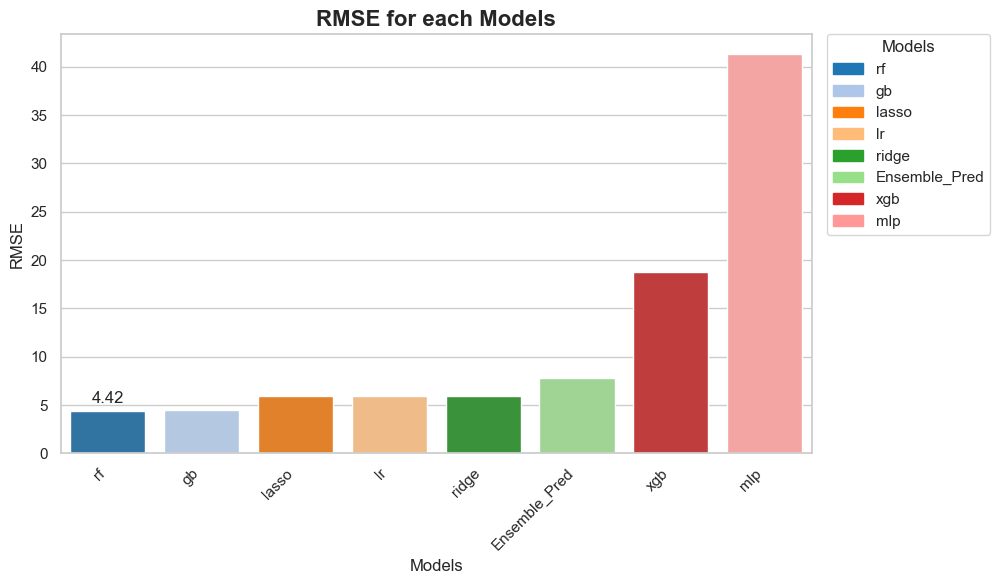

In [49]:
# Sort by RMSE
rmse_sorted = rmse_finale.sort_values('RMSE', ascending=True)

# Generate a unique color for each model
models = rmse_sorted['Model'].tolist()
colors = sns.color_palette('tab20', n_colors=len(models))
color_map = dict(zip(models, colors))

# Set Seaborn style
sns.set(style="whitegrid")

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot with custom color mapping
sns.barplot(
    data=rmse_sorted,
    x='Model',
    y='RMSE',
    palette=color_map,
    ax=ax
)

# Add labels
ax.bar_label(ax.containers[0], fmt='%.2f', padding=3)

# Titles and labels
ax.set_title('RMSE for each Models', fontsize=16, fontweight='bold')
ax.set_xlabel('Models', fontsize=12)
ax.set_ylabel('RMSE', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Custom legend with colored patches
legend_handles = [mpatches.Patch(color=color_map[model], label=model) for model in models]
ax.legend(
    handles=legend_handles,
    title='Models',
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0,
    frameon=True,
    fancybox=True
)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()